# PhageHostLearn - v3 (Klebsiella)

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

**Architecture of this framework**: 

- protein language embeddings of RBPs and loci proteins (single-instance) as inputs
- HDC projections of those embeddings
- Aggregation of the projections (multi-instance) 
- Binding to signatures
- PCA and RF

(alternatively: first do PCA on aggregates, then concat and pass to RF)

**Overview of the notebook**:

1. [Defining the necessary functions](#functions)
2. [Transform the loci sequences into embeddings](#lociembed) using hyperdimensional vectors
3. [Transform the RBP sequences into embeddings](#rbpembed) using hyperdimensional vectors
4. [Compute joint features: bind or concat](#joint)
5. [PCA and RF](#machinelearning)
6. PCA + RF LOGOCV

## 0 - Libraries and directories

In [1]:
using CSV
using MLJ
using Test
using JSON
using Plots
using FASTX
using MLBase
using Colors
using Random
using XGBoost
using StatsBase
using Statistics
using DataFrames
using ScikitLearn
using EvalMetrics
using BioAlignments
using ProgressMeter
using LinearAlgebra
using ProgressMeter
using BioAlignments
using DelimitedFiles
using MultivariateStats
using ScikitLearn.Pipelines: Pipeline
using ScikitLearn.CrossValidation: train_test_split
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn.Skcore: make_scorer

@sk_import decomposition: PCA
@sk_import ensemble: RandomForestClassifier
@sk_import metrics: roc_auc_score

push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing

general_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data" # general directory
results_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models"
data_suffix = "Valencia"; # choose a suffix for the created data files

┌ Info: Precompiling HyperdimensionalComputing [top-level]
└ @ Base loading.jl:1342


## 1 - Functions<a name="functions"></a>

In [2]:
function file_to_array(file)
    """
    Function that reads a FASTA file and puts its sequences in an array.
    """
    sequences = []
    reader = FASTA.Reader(open(file, "r"))
    for record in reader
        seq = FASTA.sequence(record)
        push!(sequences, seq)
    end
    return sequences
end

file_to_array (generic function with 1 method)

In [3]:
function mean_reciprocal_rank(queries)
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    if isa(queries, Matrix)
        queries_list = [queries[i,:] for i in 1:size(queries)[1]]
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries_list]
    else
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries]
    end
    return mean(reciprocal_ranks)
end

mean_reciprocal_rank (generic function with 1 method)

In [4]:
function recallatk(queries, k)
    """
    recall at top K for binary problems. Relevant items should be labeled as 1.
    
    Input: 
    - queries: list of lists of queries that are sorted (i.e. true labels sorted by prediction score)
    - k: the top you want to look at
    """
    recalls_k = [sum(query[1:k] .== 1) / sum(query .== 1) for query in queries]
    return mean(recalls_k)
end

recallatk (generic function with 1 method)

In [5]:
function hitratio(queries, k)
    """
    hit ratio for in the first k elements (sorted queries)
    """
    return sum([1 for query in queries if sum(query[1:k]) > 0]) / length(queries)
end

hitratio (generic function with 1 method)

In [6]:
function sort_label_matrix(score_matrix, label_matrix)
    """
    This function sorts the label matrix based on the score matrix.
    It does so per row (corresponding to bacteria in our setting).
    
    WARNING: The sortperm function will rank equal elements by ascending index order. 
    This potentially can cause an underestimation of performance (MRR), as it can be that 
    an irrelevant 0 appears earlier and then is place before a relevant 1.
    """
    @assert size(label_matrix) == size(score_matrix)
    sorted_matrix = zeros(Int64, size(label_matrix)[1], size(label_matrix)[2])
    for i in 1:size(label_matrix)[1] # loop over rows
        label_row = label_matrix[i,:]
        score_row = score_matrix[i,:]
        sorted_row = label_row[sortperm(score_row, rev=true)]
        sorted_matrix[i,:] = sorted_row
    end
    return sorted_matrix
end

sort_label_matrix (generic function with 1 method)

In [7]:
function mrr_from_scores(score_matrix, label_matrix)
    """
    This function is a wrapper for the previous functions that computes
    the MRR starting from a matrix of (prediction) scores, a threshold above
    which to consider an interaction positive and a label matrix.
    """
    # sort the matrix per row and compute
    replace!(label_matrix, missing => 0)
    sorted_matrix = sort_label_matrix(score_matrix, label_matrix)
    
    return mean_reciprocal_rank(sorted_matrix)
end

mrr_from_scores (generic function with 1 method)

In [8]:
function auc_from_scores(scores_flat, labels_flat)
    """
    This function computes the AUC from raw scores returned by ScikitLearn classifiers.
    For the AUC, we need the flat versions of scores and labels that don't contain missing 
    values (if not, this will skew the results).
    
    Dependencies: MLJ
    """
    c = ["neg", "pos"]
    labels_cat = categorical(c[labels_flat .+ 1])
    scores_uni = [UnivariateFinite(categorical(["neg", "pos"]), [1.0 - p, p]) for p in scores_flat]
    AUC = auc(scores_uni, labels_cat)
    return AUC
end

auc_from_scores (generic function with 1 method)

In [9]:
function compute_performance(score_matrix, label_matrix, scores_flat, labels_flat)
    """
    Wrapper function that computes the two relevant results we want to compare for 
    our models: the ROC AUC and the MRR.    
    """
    MRR = mrr_from_scores(score_matrix, label_matrix) # compute MRR
    AUC = auc_from_scores(scores_flat, labels_flat) # compute AUC
    return MRR, AUC
end

compute_performance (generic function with 1 method)

In [10]:
hdv(n) = rand((-1,1), n, 10000)
binned(v) = round(Int, (v+10) * 1000) + 1
shift(x, k=1) = circshift(x, k)

shift (generic function with 2 methods)

In [11]:
function range_hdvs(steps)
    """
    Generate HDVs from a stepwise range.
    """
    k = length(steps) - 1
    V = hdv(k+1)
    for i in 2:k+1
        for j in 1:10000
            V[i,j] = rand() < 1 / k ? -V[i-1,j] : V[i-1,j]
        end
    end
    return V
end

range_hdvs (generic function with 1 method)

In [24]:
bundling(U::Matrix{Int}) = sum(U, dims=1)[:] .|> sign
bundling(U::Matrix{Float64}) = sum(U, dims=1)
binding(xs::Vector{Int}...) = reduce(.*, xs)
binding(xs::Vector{Float64}...) = reduce(.*, xs)
binding_binary(xs::Vector{Int}...) =  .⊻

binding_binary (generic function with 1 method)

## 2 - Loading language embeddings

In [12]:
RBP_embeddings = DataFrame(CSV.File(general_dir*"/esm2_embeddings_rbpValencia.csv"));

In [13]:
loci_embeddings = DataFrame(CSV.File(general_dir*"/esm2_embeddings_lociValencia.csv"));

## 3 - Project embeddings into hyperdimensional space

So far, we've seen that projecting with bipolar vectors does not improve performance over just using language embeddings. Perhaps bipolar undoes the similarity conservation of matrix multiplication because some sums will become subtractions…

Binary vectors also don't seem to improve much. But the thing is we don't really know how much info we're losing by doing the PCA... Perhaps we need to stay in high dim space to have the benefit of the multi-instance?

Let's try with GradedHDVs AND cut the PCA.

#### Using matrix multiplication

In [14]:
# get actual values
rbp_emb = RBP_embeddings[:, 3:end]
loci_emb = loci_embeddings[:, 2:end];

In [17]:
# create hdv matrix where # of rows correspond to language embedding dimension
hdv_matrix = zeros(Float64, size(rbp_emb)[2], 10000)
for i in 1:size(rbp_emb)[2]
    hdv_matrix[i,:] = BipolarHDV(10000)
end

In [21]:
# do RBP matrix multiplication and turn into bipolar array
rbphdc = Matrix(rbp_emb) * hdv_matrix .|> sign
#rbphdc = convert(Matrix{Int64}, rbphdc);

In [22]:
# do loci matrix multiplication and turn into bipolar array
locihdc = Matrix(loci_emb) * hdv_matrix .|> sign
#locihdc = convert(Matrix{Int64}, locihdc);

#### Using range HDVs

In [81]:
steps = -10.0:0.001:1
hdv_matrix = range_hdvs(steps);

In [114]:
# project RBP embeddings into hyperspace
rbphdc = zeros(size(rbp_emb)[1], 10000)
for i in 1:size(rbp_emb)[1]
    # loop over the language space
    projections = []
    for j in 1:size(rbp_emb)[2]
        # for each position, get the index and correct HDV
        this_projection = hdv_matrix[binned(rbp_emb[i,j]), :]
        # shift for the position of the language space
        this_projection = circshift(this_projection, j-1)
        push!(projections, this_projection)
    end
    rbphdc[i,:] = binding(projections...)
end
rbphdc = convert(Matrix{Int64}, rbphdc);

In [116]:
# project loci embeddings into hyperspace
locihdc = zeros(size(loci_emb)[1], 10000)
for i in 1:size(loci_emb)[1]
    # loop over the language space
    projections = []
    for j in 1:size(loci_emb)[2]
        # for each position, get the index and correct HDV
        this_projection = hdv_matrix[binned(loci_emb[i,j]), :]
        # shift for the position of the language space
        this_projection = circshift(this_projection, j-1)
        push!(projections, this_projection)
    end
    locihdc[i,:] = binding(projections...)
end
locihdc = convert(Matrix{Int64}, locihdc);

## 3b - Correlation between projections

How is the information of the HDC projection preserved compared to the original language embeddings. We would expect it to be conserved, as you don't lose any info with matrix multiplication. One way to check is to compute distances between the RBPs or loci and see if these distances are preserved when we project into hyperdimensional space. 

If this works out but the performance is still not good, then the problem resides at the level of multi-RBP aggregation or signature binding...

In [50]:
cosine_similarity(x,y) = dot(x,y)/(norm(x)*norm(y));

In [51]:
# compute cosine similarities for RBP embeddings
hdc_sim = zeros(Float64, size(rbphdc)[1], size(rbphdc)[1])
for i in 1:size(rbphdc)[1]
    for j in 1:size(rbphdc)[1]
        hdc_sim[i,j] = cosine_similarity(rbphdc[i, :], rbphdc[j, :])
    end
end

In [52]:
# compute cosine similarities for RBP embeddings
lan_sim = zeros(Float64, size(rbphdc)[1], size(rbphdc)[1])
for i in 1:size(rbphdc)[1]
    for j in 1:size(rbphdc)[1]
        lan_sim[i,j] = cosine_similarity(rbp_emb[i, :], rbp_emb[j, :])
    end
end

In [53]:
# Make RBP scatter plot
h = plot(seriestype=:scatter)
for i in 1:size(rbphdc)[1]
    plot!([hdc_sim[i, :]], [lan_sim[i, :]], seriestype=:scatter, label="")
end
plot!(xlabel="HDC cosine similarity", xguidefontsize=9, ylabel="Language cosine similarity", yguidefontsize=9, size=(500, 400), dpi=300)
this_cor = cor(vcat(hdc_sim...), vcat(lan_sim...))
plot!(title="correlation: "*string(round(this_cor, digits=4)))
savefig(h, results_dir*"/v3.0/HDC_language_similarity_scores_gradedMatMul.png")

## 4 - Aggregate single-instances to multi-instance HDVs

In [27]:
multirbphdc = zeros(Float64, length(unique(RBP_embeddings.phage_ID)), 10000)
for (i, phageid) in enumerate(unique(RBP_embeddings.phage_ID))
    subset = rbphdc[RBP_embeddings.phage_ID .== phageid, :]
    multirbphdc[i, :] = bundling(subset)
end
multirbphdc = convert(Matrix{Float64}, multirbphdc);

In [ ]:
# aggregate loci proteins if building up from single locus protein embeddings!

## 5 - Binding to joint signatures

In [29]:
# load data
LociBase = JSON.parsefile(general_dir*"/Locibase"*data_suffix*".json")
seros = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"))

IM = DataFrame(CSV.File(general_dir*"/phage_host_interactions"*data_suffix*".csv"))
rename!(IM,:Column1 => :Host)
interaction_matrix = Matrix(IM[1:end, 2:end]);

In [30]:
# compute sigatures for loci x RBP embeddings by BINDING
signatures = []
labels = []
groups_loci = []
groups_phage = []
for (i, accession) in enumerate(collect(keys(LociBase)))
    for (j, phage_id) in enumerate(unique(RBP_embeddings.phage_ID))
        subset = filter(row -> row.Host == accession, IM)
        interaction = subset[!, phage_id][1]
        if isequal(interaction, 1) || isequal(interaction, 0)
            signature = binding(locihdc[i,:], multirbphdc[j, :])
            push!(signatures, signature)
            push!(labels, trunc(Int, interaction))
            push!(groups_loci, i)
            push!(groups_phage, j)
        end
    end
end

In [31]:
# put the signatures in a matrix for sklearn
features = zeros(Float64, length(signatures), 10000)

for i in range(1, length=length(signatures))
    features[i,:] = signatures[i]
end
features = convert(Matrix{Float64}, features);

## 5 - PCA + RF K-fold evaluation<a name="machinelearning"></a>

RF + language embeddings gets to around 70-76%...

language - Bipolar MatMul - Bind - RF: around 68%

language - Graded MatMul - Bind - RF: around 73%

Graded HDVs show promise looking at hyperparam tuning results! now around 65% while before always around 53%

In [32]:
# shuffle and set test set aside
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels);

In [33]:
# define model and CV
rf = RandomForestClassifier(class_weight="balanced", n_jobs=6)
#pca = PCA()
#pipe = Pipeline([("pca", pca), ("rf", rf)])
params = Dict("n_estimators"=>[750, 1000, 1250], "max_depth"=>[3, 5, 7, 9])
cv = CrossValidation.StratifiedKFold(y_train, n_folds=5, shuffle=true, random_state=42);

In [34]:
# do hyperparameter tuning
rocauc = make_scorer(roc_auc_score)
rf_tuned = GridSearchCV(rf, params, cv=cv, scoring=rocauc, verbose=3)
ScikitLearn.fit!(rf_tuned, X_train, y_train)
println(rf_tuned.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.63257  -  2.7s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.64534  -  2.3s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.62887  -  2.5s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.71775  -  2.2s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.66886  -  2.3s
[CV] n_estimators=1000, max_depth=3
[CV] n_estimators=1000, max_depth=3, score=0.63092  -  2.7s
[CV] n_estimators=1000, max_depth=3
[CV] n_estimators=1000, max_depth=3, score=0.64403  -  2.8s
[CV] n_estimators=1000, max_depth=3
[CV] n_estimators=1000, max_depth=3, score=0.62458  -  2.7s
[CV] n_estimators=1000, max_depth=3
[CV] n_estimators=1000, max_depth=3, score=0.71906  -  2.7s
[CV] n_estimators=1000, max_depth=3
[CV] n_estimators=1000, max_depth=3, score=0.6629

In [72]:
# test set evaluation
rf = RandomForestClassifier(n_estimators=1000, max_depth=3, class_weight="balanced", n_jobs=6)
#pca = PCA(n_components=200)
#pipe = Pipeline([("pca", pca), ("rf", rf)])
model = ScikitLearn.fit!(rf, X_train, y_train)
scores_pos = ScikitLearn.predict_proba(model, X_test)[:,2]
roc_auc_score(y_test, scores_pos)

0.7301672079460386

In [73]:
# save scores for plotting
results = DataFrame(labels=y_test, scores=scores_pos)
CSV.write(results_dir*"/v3.0/hdc_language_sequence.csv", results)

"/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models/v3.0/language_hdc_gradedmatmul.csv"

In [20]:
# randomized labels
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
pca = PCA(n_components=200)
pipe = Pipeline([("pca", pca), ("rf", rf)])
y_shuffled = shuffle(y_train)
model = ScikitLearn.fit!(pipe, X_train, y_shuffled)
scores_pos = ScikitLearn.predict_proba(model, X_test)[:,2]
println(roc_auc_score(y_test, scores_pos))
results = DataFrame(labels=y_test, scores=scores_pos)
CSV.write(results_dir*"/v2.2/hdc_bind_rf_scores_random.csv", results)

0.5316325387869025


"/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models/v2.2/hdc_bind_rf_scores_random.csv"

## 6 - PCA+RF in LOGOCV setting

In [75]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=3, class_weight="balanced", n_jobs=6)
noauc_scores = []
rocauc_scores = []
prauc_scores = []
sero_groups = []
ranked_q = []
p = Progress(200)

for item in unique(groups_loci)
    # define training and test data
    x_train = features[groups_loci .!= item, :]
    y_train = labels[groups_loci .!= item]
    x_test = features[groups_loci .== item, :]
    y_test = labels[groups_loci .== item]
    
    # train the model
    model = ScikitLearn.fit!(rf, x_train, y_train)
    
    # make predictions and keep the scores
    scores_pos = ScikitLearn.predict_proba(model, x_test)[:,2]
    try
        roc_auc = roc_auc_score(y_test, scores_pos)
        pr_auc = au_prcurve(convert(Vector{Int64}, y_test), convert(Vector{Float64}, scores_pos))
        push!(rocauc_scores, roc_auc)
        push!(prauc_scores, pr_auc)
        this_sero = seros.sero[item]
        push!(sero_groups, this_sero)
        sorted_query = y_test[sortperm(scores_pos, rev=true)] # sort labels to compute MRR later
        push!(ranked_q, sorted_query)
    catch
        push!(noauc_scores, scores_pos)
    end
    
    # pbar update
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 2:09:21


In [76]:
# print scores
println("ROC AUC: ", mean(rocauc_scores))
println("PR AUC: ", mean(prauc_scores))
println("MRR: ", mean_reciprocal_rank(ranked_q))
println("Top 10 Recall: ", recallatk(ranked_q, 10))

# save scores for plotting
logo_results = DataFrame(sero=sero_groups, rocauc_scores=rocauc_scores, prauc_scores=prauc_scores, 
                            ranked_queries=ranked_q)
CSV.write(results_dir*"/v3.0/hdc_language_sequence_logocv_results.csv", logo_results);

ROC AUC: 0.683953514026349
PR AUC: 0.2928992405169087
MRR: 0.4031040408495346
Top 10 Recall: 0.4427446569178853


In [79]:
logo_results = DataFrame(CSV.File(results_dir*"/v3.0/hdc_language_sequence_logocv_results.csv"))
ranked_queries = [eval(Meta.parse(logo_results.ranked_queries[i])) for i in 1:length(logo_results.ranked_queries)]
ks = LinRange(1, 46, 46)
recalls = [recallatk(ranked_queries, trunc(Int, k)) for k in ks]
hits = [hitratio(ranked_queries, trunc(Int, k)) for k in ks]
plot(ks, recalls, lw=2.5, label="Recall", c="#508AA8", legend=:topleft, dpi=400)
plot!(ks, hits, lw=2.5, label="Hit ratio", c="#BA2D0B")
ylims!((0.1, 1))
savefig(results_dir*"/v3.0/hdc_language_logocv_recall_hitratio.png")

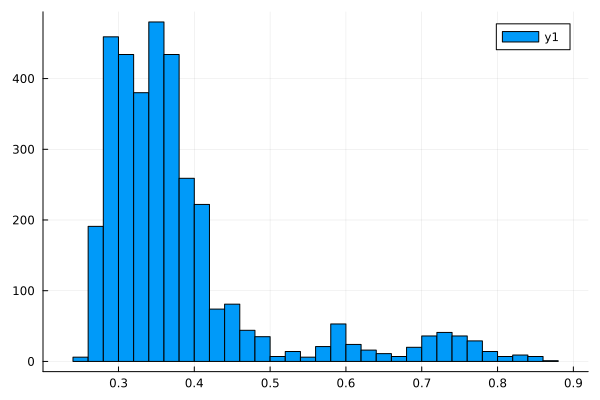

In [80]:
scores_flat = vcat(noauc_scores...)
histogram(scores_flat) # not all scores are very low...

## 7 - PCA+RF single-RBP LOGOCV

## X - Out of use

## X - Tests

In [69]:
@testset "tests for MRR" begin
    @test mean_reciprocal_rank([[0, 0, 0], [0, 1, 0], [1, 0, 0]]) == 0.5
    @test mean_reciprocal_rank([[1, 0, 0], [1, 1, 0], [1, 0, 0]]) == 1
    A = [0 0 0; 0 1 0; 1 0 0] # Matrix
    @test mean_reciprocal_rank(A) == 0.5
end;

Test Summary: | Pass  Total
tests for MRR |    3      3


In [19]:
@testset "test for Recall@K" begin
    @test recallatk([[1, 0, 0, 1, 0]], 3) == 0.5
    @test recallatk([[1, 0, 0, 1, 0], [1, 1, 0, 0, 0]], 3) == 0.75
end;

Test Summary:     | Pass  Total
test for Recall@K |    2      2


In [51]:
@testset "tests for constructing relevant matrix" begin
    preds = [0 0 1; 1 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == labels # all TPs
    preds = [0 0 0; 1 0 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 0 0; 0 0 0] # missed TPs
    preds = [0 1 0; 1 1 0; 1 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 1 0; 0 0 0] # FPs
end;

Test Summary:                          | Pass  Total
tests for constructing relevant matrix |    3      3


In [122]:
@testset "tests for sorting label matrix" begin 
    rel = [0 0 1; 1 1 0; 0 0 0]
    scores = [0.5 0.3 1; 1 0.3 0.7; 0.2 0.3 0.3]
    @test sort_label_matrix(scores, rel) == [1 0 0; 1 0 1; 0 0 0]
    
    rel = [0 0 1; 1 1 0; 0 0 0]
    scores = [1 0.3 1; 1 0.3 0.7; 0.2 0.3 0.3] # equal score for 0 and 1
    @test sort_label_matrix(scores, rel) == [0 1 0; 1 0 1; 0 0 0] # equals will appear in ascending order
end;

Test Summary:                  | Pass  Total
tests for sorting label matrix |    2      2


In [124]:
@testset "tests pipeline" begin
    preds = [0 0 1; 0 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    scores = [0 0.2 0.5; 0.3 0.2 0.1; 0.2 0.4 0.3]
    relm = construct_relevant_matrix(preds, labels)
    sortm = sort_label_matrix(scores, relm)
    @test construct_relevant_matrix(preds, labels) == [0 0 1; 0 1 0; 0 0 0]
    @test sort_relevant_matrix(relm, scores) == [1 0 0; 0 1 0; 0 0 0] 
    @test mean_reciprocal_rank(sortm) == 0.5
end;

Test Summary:  | Pass  Total
tests pipeline |    3      3


In [28]:
@testset "tests mrr from scores" begin
    labels = [0 0 1; 1 1 0; 0 0 0]
    scores = [0 0.2 0.5; 0.3 0.5 0.6; 0.2 0.4 0.3]
    @test mrr_from_scores(scores, labels, 0.4) == 0.5
end;

Test Summary:         | Pass  Total
tests mrr from scores |    1      1
